# Model Training and Prediction

This notebook trains machine learning models to predict development timelines using grouped cross-validation. It implements SHAP-based feature selection within each fold to prevent data leakage and evaluates models on unseen countries.

In [ ]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold
from collections import defaultdict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

import matplotlib.pyplot as plt

# SHAP
import shap

# XGBoost
import xgboost as xgb

/home/azizbek/INHA University/GDP per capita projection (project)/gdp_prediction_developing/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

Load training and test datasets. Remove test countries that appear in the training set to ensure valid evaluation.

In [2]:
TRAIN_PATH = '../data/ML_data/train_panel_years_to_developed.csv'
TEST_PATH  = '../data/ML_data/predict_panel_features.csv'

target_col = 'years_to_developed'
top_k_features = 30   # number of top features to keep

df_train = pd.read_csv(TRAIN_PATH)
df_test  = pd.read_csv(TEST_PATH)

print("Train shape:", df_train.shape)
print("Test shape :", df_test.shape)

# Drop countries from test that also appear in train
if "Country Name" in df_train.columns and "Country Name" in df_test.columns:
    train_countries = set(df_train["Country Name"].unique())
    before = len(df_test)
    df_test = df_test[~df_test["Country Name"].isin(train_countries)].reset_index(drop=True)
    dropped = before - len(df_test)
    print(f"Dropped {dropped} rows from test because Country Name exists in train.")
else:
    print("Warning: 'Country Name' column not found in train or test; no dropping performed.")

# Separate features/target
X_full = df_train.drop(columns=[target_col])
y_full = df_train[target_col]
X_test_full = df_test.copy()


Train shape: (1882, 250)
Test shape : (4358, 249)
Dropped 1758 rows from test because Country Name exists in train.


## Grouped Cross-Validation with SHAP Feature Selection

Implement cross-validation grouped by country to avoid data leakage. In each fold, SHAP values are computed to select the top features, ensuring feature selection happens only on training data.

In [ ]:
# We keep the original full X/y here
X_full = df_train.drop(columns=[target_col])
y_full = df_train[target_col].values

# Groups = country names
if "Country Name" not in df_train.columns:
    raise ValueError("'Country Name' column is required for grouped CV")

groups = df_train["Country Name"].values

# Identify numeric vs categorical features ON THE FULL DATA
numeric_features_all = X_full.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_all = [c for c in X_full.columns if c not in numeric_features_all]

print("Total numeric features :", len(numeric_features_all))
print("Total categorical features:", len(categorical_features_all))

# GroupKFold: each fold holds out a set of countries
n_splits = 5  
gkf = GroupKFold(n_splits=n_splits)

# Models as before
models = {
    "linear_regression": LinearRegression(),
    "random_forest": RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        n_jobs=-1
    )
}

if xgb is not None:
    models["xgboost"] = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

print("\nModels to train:", list(models.keys()))

# To collect metrics and selected features per fold
cv_results = []
fold_selected_features = []

for fold_idx, (train_idx, val_idx) in enumerate(gkf.split(X_full, y_full, groups=groups), start=1):
    print(f"Fold {fold_idx}/{n_splits}")

    # Split by index
    X_tr = X_full.iloc[train_idx].copy()
    y_tr = y_full[train_idx]
    X_val = X_full.iloc[val_idx].copy()
    y_val = y_full[val_idx]

    train_countries = set(df_train.iloc[train_idx]["Country Name"])
    val_countries   = set(df_train.iloc[val_idx]["Country Name"])
    print("Train countries:", len(train_countries))
    print("Val countries  :", len(val_countries))

    # ---------------------------------------------------------------
    # 2a. Feature selection WITHIN THIS FOLD ONLY (SHAP)
    # ---------------------------------------------------------------
    X_tr_num = X_tr[numeric_features_all]

    shap_model = RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        n_jobs=-1
    )
    shap_model.fit(X_tr_num, y_tr)

    sample_size = min(1000, len(X_tr_num))
    X_sample = X_tr_num.sample(n=sample_size, random_state=42)

    explainer = shap.TreeExplainer(shap_model)
    shap_raw = explainer.shap_values(X_sample)

    if isinstance(shap_raw, list):
        shap_matrix = shap_raw[0]
    else:
        shap_matrix = shap_raw

    mean_abs_shap = np.abs(shap_matrix).mean(axis=0)

    shap_importance_fold = (
        pd.DataFrame({
            "feature": numeric_features_all,
            "mean_abs_shap": mean_abs_shap
        })
        .sort_values("mean_abs_shap", ascending=False)
        .reset_index(drop=True)
    )

    top_features_fold = shap_importance_fold["feature"].head(top_k_features).tolist()
    fold_selected_features.append(top_features_fold)

    print(f"Top {top_k_features} SHAP features for fold {fold_idx}:")
    print(top_features_fold)

    # Subset train/val to these top features + any categorical features
    keep_features = top_features_fold + [
        c for c in categorical_features_all if c in X_tr.columns
    ]
    X_tr_fs = X_tr[keep_features]
    X_val_fs = X_val[keep_features]

    # ---------------------------------------------------------------
    # 2b. Preprocessing (defined per fold on selected features)
    # ---------------------------------------------------------------
    numeric_features = X_tr_fs.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X_tr_fs.select_dtypes(exclude=[np.number]).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)
        ]
    )

    # ---------------------------------------------------------------
    # 2c. Train each model and evaluate on this fold’s validation
    # ---------------------------------------------------------------
    for name, est in models.items():
        print(f"\nTraining {name} on fold {fold_idx}...")

        pipe = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", est)
        ])

        pipe.fit(X_tr_fs, y_tr)
        val_pred = pipe.predict(X_val_fs)

        mse = mean_squared_error(y_val, val_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_val, val_pred)
        r2 = r2_score(y_val, val_pred)

        cv_results.append({
            "fold": fold_idx,
            "model": name,
            "rmse": rmse,
            "mae": mae,
            "r2": r2
        })

        print(f"Fold {fold_idx} - {name}: RMSE={rmse:.3f}, MAE={mae:.3f}, R2={r2:.4f}")

Total numeric features : 247
Total categorical features: 2

Models to train: ['linear_regression', 'random_forest', 'xgboost']

Fold 1/5
Train countries: 44
Val countries  : 12
Top 30 SHAP features for fold 1:
['Life expectancy at birth, female (years)', 'Fixed telephone subscriptions (per 100 people)', 'Rural population (% of total population)', 'Urban population (% of total population)', 'GDP deflator (base year varies by country)', 'Life expectancy at birth, total (years)', 'Households and NPISHs final consumption expenditure (% of GDP)', 'Population ages 80 and above, male (% of male population)', 'Year.1', 'Year', 'Population ages 35-39, female (% of female population)', 'Arable land (hectares)', 'Population ages 75-79, male (% of male population)', 'Total fisheries production (metric tons)', 'Arable land (% of land area)', 'Mortality rate, neonatal (per 1,000 live births)', 'Merchandise exports (current US$)', 'Agricultural land (% of land area)', 'Official exchange rate (LCU per

## Cross-Validation Results

Display detailed performance metrics for each fold and model.

In [4]:
cv_results_df = pd.DataFrame(cv_results)
print("\nCross-validated performance (grouped by country):")
display(cv_results_df)

print("\nMean performance by model (across folds):")
display(cv_results_df.groupby("model")[["rmse", "mae", "r2"]].mean())


Cross-validated performance (grouped by country):


,fold,model,rmse,mae,r2
0,1,linear_regression,14.958495,12.020190,-0.180846
1,1,random_forest,7.750215,5.380969,0.683010
2,1,xgboost,7.854638,5.331133,0.674411
3,2,linear_regression,14.421199,11.601854,-0.125237
4,2,random_forest,8.236348,6.001920,0.632962
5,2,xgboost,7.620719,5.401290,0.685780
6,3,linear_regression,11.567515,10.155720,0.147407
7,3,random_forest,8.039688,6.427283,0.588149
8,3,xgboost,7.544775,5.618891,0.637295
9,4,linear_regression,11.431710,10.224691,0.159628



Mean performance by model (across folds):


,rmse,mae,r2
model,,,
linear_regression,12.739447,10.848717,0.034191
random_forest,7.416257,5.566721,0.670046
xgboost,7.055905,5.160397,0.702293


## Model Performance Summary

Calculate average metrics across all folds for each model.

In [5]:
summary = (
    cv_results_df
    .groupby("model")[["rmse", "mae", "r2"]]
    .mean()
    .reset_index()
)

display(summary)

,model,rmse,mae,r2
0,linear_regression,12.739447,10.848717,0.034191
1,random_forest,7.416257,5.566721,0.670046
2,xgboost,7.055905,5.160397,0.702293


## Performance Visualizations

Visualize model performance using bar charts for RMSE, MAE, and R² metrics.

/tmp/ipykernel_5092/3946829071.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(summary["model"], rotation=20, ha="right")
/tmp/ipykernel_5092/3946829071.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(summary["model"], rotation=20, ha="right")


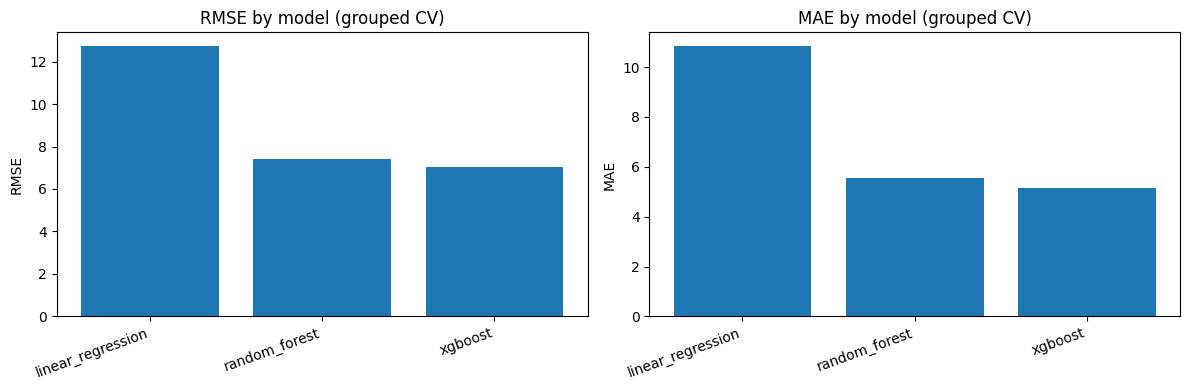

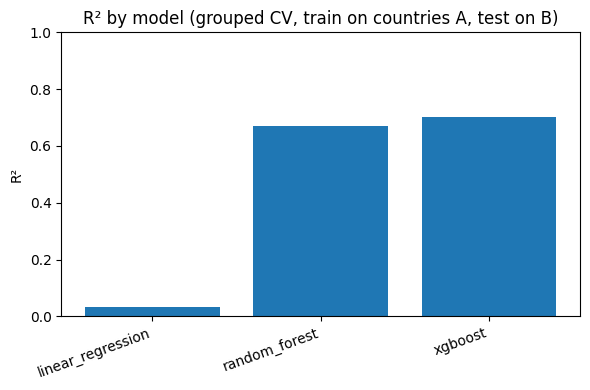

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# RMSE
axes[0].bar(summary["model"], summary["rmse"])
axes[0].set_title("RMSE by model (grouped CV)")
axes[0].set_ylabel("RMSE")
axes[0].set_xticklabels(summary["model"], rotation=20, ha="right")

# MAE
axes[1].bar(summary["model"], summary["mae"])
axes[1].set_title("MAE by model (grouped CV)")
axes[1].set_ylabel("MAE")
axes[1].set_xticklabels(summary["model"], rotation=20, ha="right")

plt.tight_layout()
plt.show()

# R²
plt.figure(figsize=(6, 4))
plt.bar(summary["model"], summary["r2"])
plt.title("R² by model (grouped CV, train on countries A, test on B)")
plt.ylabel("R²")
plt.ylim(0, 1)  # because R² is between 0 and 1
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


## R² by Fold

Plot R² scores across different folds to assess model stability when tested on different country groups.

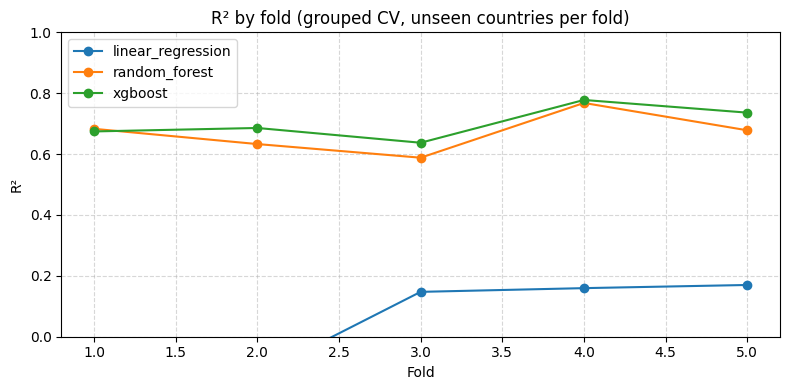

In [7]:
# Make sure folds are sorted
cv_results_df_sorted = cv_results_df.sort_values("fold")

plt.figure(figsize=(8, 4))
for model in cv_results_df_sorted["model"].unique():
    tmp = cv_results_df_sorted[cv_results_df_sorted["model"] == model]
    plt.plot(tmp["fold"], tmp["r2"], marker="o", label=model)

plt.title("R² by fold (grouped CV, unseen countries per fold)")
plt.xlabel("Fold")
plt.ylabel("R²")
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## Key Findings

XGBoost consistently achieves the highest R² across folds, demonstrating robust performance when evaluated on unseen countries. The model shows stable performance regardless of which countries are held out for validation.